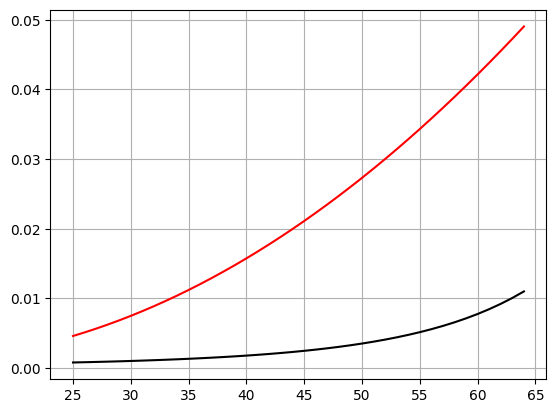

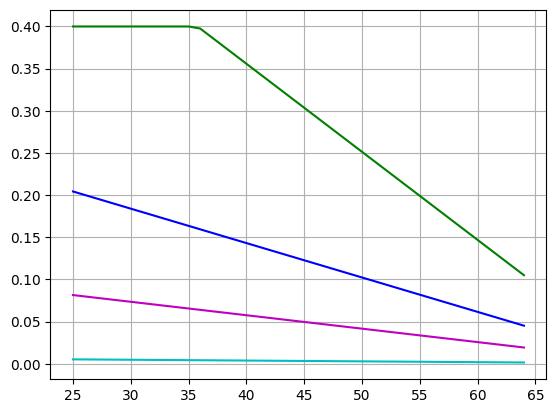

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscount(self,fIRate):# you set v
        vTemp = 1./(1.+fIRate)
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):# you set p_{ij}(t,t+1)
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):# you set a_{i}^{pre}(t) 
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):# you set a_{ij}^{post}(t)
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP # This is Chapman Kolmogorov
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.4f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
                for j in range(self.iNrStates):
                    xBar.append(i+(j)*1./self.iNrStates)
                    hBar.append(self.dGetCF(iStart,iStop,i,j))
                    bBar.append(0)
                    cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1
        

def mua(x): # Mortality active person
    return(np.exp(-7.85785 + 0.01538*x + 0.000577355*x**2))

def mui(x): #Mortality of diabled person
    return(mua(x)+0.008)

def sigma(x): #Inception rate to become disablex (i(x))
    return(3.e-4 * (8.4764-1.0985*x + 0.055*x**2))

def alpha(x,k):
    return(0.773763-0.01045*(x-k + 1))

def rx(x,k,n=8): #Reachtivation as function of age at time becoming disabled and time being disabled
    if (k>= n): return(0.)
    return(max(0,min(0.4,np.exp(-0.94*(k-1)) * alpha(x, k))))



x=[]
ix =[]
qx=[]
rxv=[]
rxv1=[]
rxv2=[]
rxv5=[]

for i in range(25,65):
    x.append(i)
    qx.append(mua(i))
    ix.append(sigma(i))
    rxv.append(rx(i,1))
    rxv2.append(rx(i,3))
    rxv1.append(rx(i,2))
    rxv5.append(rx(i,6))

plt.figure(1)
plt.plot(x,qx,"k",x,ix,'r')
plt.grid(True)


plt.figure(2)
plt.plot(x,rxv,'g',x,rxv1,'b',x,rxv2,'m',x,rxv5,'c')
plt.grid(True)

def QxA(gender, x, t):
    return(mua(x))

def QxI(gender, x, t):
    return(mui(x))

def Ix(gender, x):
    return(sigma(x))

def Rx(gender,x,k):
    return(rx(x,k,n=20))
    

In [2]:
def ConstantBenefit(x,param=[]):
    if len(param)>0:
        iState = param[0]
    return(1.)

def ConstantBenefitWP1(x,param=[]):
    if len(param)>0:
        iState = param[0]
    if iState > 1:
        return(1.)
    return(0)

def ZeroBenefit(x,param=[]):
    return(0.)

class Diability:
    def __init__(self,QxA, QxI, Ix, Rx,iRetAge=65, i=0.02,omega=120,t0 = 2020, iDisStates=6):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit 
        self.psymBRetirment = ConstantBenefit
        self.iRetAge = iRetAge
        self.psymP = ZeroBenefit # We incialise Premium only beeing paid for active members
        self.psymQxA = QxA
        self.psymQxI = QxI
        self.psymIx = Ix
        self.psymRx = Rx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        self.iDisStates = iDisStates
        self.bInit = False
        
    def InitMarkov(self,gender,param):
        self.bInit = True
        self.symM = Markov()
        self.symM.vDefineModel(self.iDisStates+2)
        self.symM.vSetDiscount(self.dIrate)
        for i in range(0,self.nOmega):
            premium = self.psymP(i)
            qxa = self.psymQxA (gender, i, 0) #calender year not reflected
            qxi = self.psymQxI (gender, i, 0) #calender year not reflected
            ix = self.psymIx (gender, i)
            #print(i,qxa,qxi,ix)
            # State 0: active
            # State 1 ... iDisStates: Diabled States
            # State 1+ iDisStates: Death State
            
            self.symM.vSetPij(i,0,0, 1. - ix - qxa)
            self.symM.vSetPij(i,0,1, ix)
            self.symM.vSetPij(i,0,self.iDisStates+1, qxa)
            for j in range(self.iDisStates):
                annuity = self.psymB(i,param=[j])
                annuityRet = self.psymBRetirment(i)
                rx = self.psymRx(gender, i, j)
                #print("+",i,j,rx)
                if j<self.iDisStates-1: 
                    self.symM.vSetPij(i,1+j,1+j+1,1.- qxi- rx)
                    self.symM.vSetPij(i,1+j,0, rx)
                    self.symM.vSetPij(i,1+j,self.iDisStates+1, qxi)
                else:
                    self.symM.vSetPij(i,self.iDisStates,self.iDisStates, 1.- qxi)
                    self.symM.vSetPij(i,self.iDisStates,self.iDisStates+1, qxi)
                    
                self.symM.vSetPij(i,1+j,1+self.iDisStates, qxi)
                if i < self.iRetAge:
                    self.symM.vSetPre(i,1+j,1+j,annuity)
                else:
                    self.symM.vSetPre(i,1+j,1+j,annuityRet)
            if i < self.iRetAge:
                self.symM.vSetPre(i,0,0,-premium) #Premium is only paid when active (waiver of premium in case of diability)
            else:
                self.symM.vSetPre(i,0,0,annuityRet)
        
    def CalcPV(self,gender,x,s,state=0,param=[]):
        if not self.bInit: self.InitMarkov(gender,param)
        iStart = s
        iStop = x
        return(self.symM.dGetDK(iStart,iStop,i,state))
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        if not self.bInit: self.InitMarkov(gender,param)
        iStart = s
        iStop = x
        print("TBD")
        self.symM.PlotCFs(iStart,iStop)
        
    def PrintDKs(self,gender,x,s,param=[]):
        if not self.bInit: self.InitMarkov(gender,param)
        iStart = s
        iStop = x
        self.symM.PrintDKs(iStart,iStop)
    

  20 :   2.0911    8.9994   12.4090   18.3277   22.6450   24.5387   25.3373    0.0000 
  21 :   2.1168    8.9802   12.3663   18.2476   22.4337   24.2676   25.0410    0.0000 
  22 :   2.1409    8.9565   12.3174   18.1585   22.2140   23.9884   24.7367    0.0000 
  23 :   2.1630    8.9280   12.2621   18.0600   21.9855   23.7009   24.4244    0.0000 
  24 :   2.1832    8.8947   12.2001   17.9519   21.7479   23.4049   24.1037    0.0000 
  25 :   2.2010    8.8561   12.1311   17.8338   21.5012   23.1001   23.7745    0.0000 
  26 :   2.2164    8.8121   12.0549   17.7054   21.2450   22.7864   23.4366    0.0000 
  27 :   2.2291    8.7626   11.9712   17.5664   20.9790   22.4634   23.0897    0.0000 
  28 :   2.2390    8.7071   11.8797   17.4165   20.7030   22.1310   22.7337    0.0000 
  29 :   2.2459    8.6456   11.7803   17.2553   20.4168   21.7890   22.3682    0.0000 
  30 :   2.2496    8.5778   11.6726   17.0825   20.1200   21.4370   21.9931    0.0000 
  31 :   2.2499    8.5036   11.5563   16.89

AttributeError: `np.mat` was removed in the NumPy 2.0 release. Use `np.asmatrix` instead.

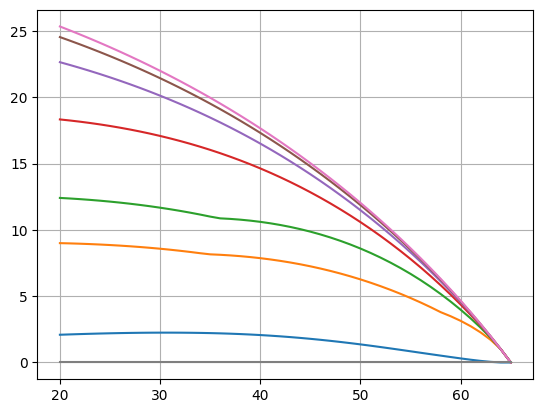

<Figure size 640x480 with 0 Axes>

In [3]:
a = Diability(QxA,QxI,Ix,Rx)
a.PrintDKs(0,20,65)
a.symM.PlotDKs(65,20)
a.CalcCF(0,20,65)

a2 = Diability(QxA,QxI,Ix,Rx)
a2.PrintDKs(0,20,110)



In [4]:
for i in range(20,65,5):
    for j in range(8):
        for k in range(8):
            pij = a.symM.dPij[i][j,k]
            if abs(pij)> 0.0005:
                print(i,j,k,pij)

20 0 0 0.9967854594139581
20 0 1 0.00255192
20 0 7 0.0006626205860418346
20 1 0 0.4
20 1 2 0.5913373794139581
20 1 7 0.008662620586041834
20 2 0 0.4
20 2 3 0.5913373794139581
20 2 7 0.008662620586041834
20 3 0 0.224694209060081
20 3 4 0.7666431703538772
20 3 7 0.008662620586041834
20 4 0 0.0893663791078939
20 4 5 0.9019710003060643
20 4 7 0.008662620586041834
20 5 0 0.03553187732605397
20 5 6 0.9558055020879042
20 5 7 0.008662620586041834
20 6 6 0.9913373794139582
20 6 7 0.008662620586041834
25 0 0 0.9945684772411233
25 0 1 0.00461667
25 0 7 0.0008148527588767643
25 1 0 0.4
25 1 2 0.5911851472411233
25 1 7 0.008814852758876765
25 2 0 0.4
25 2 3 0.5911851472411233
25 2 7 0.008814852758876765
25 3 0 0.20428390466259833
25 3 4 0.7869012425785249
25 3 7 0.008814852758876765
25 4 0 0.08139354608209672
25 4 5 0.9097916011590266
25 4 7 0.008814852758876765
25 5 0 0.03241746681951189
25 5 6 0.9587676804216114
25 5 7 0.008814852758876765
25 6 6 0.9911851472411233
25 6 7 0.008814852758876765
30 

In [5]:
DisStates = [1,2,3,4,5,6,15]
Pointers = []

Ages = [20, 40, 60]

for i in DisStates:
    Pointers.append(Diability(QxA,QxI,Ix,Rx,iDisStates=i))


for j in Ages:
    print("\n \nAge", j)
    for k in range(len(DisStates)):
        if not Pointers[k].bInit: Pointers[k].InitMarkov(0,[])
        print(" Dis States %d --> %f [Active]"%(DisStates[k],Pointers[k].symM.dGetDK(65,20,j,0)))



 
Age 20
 Dis States 1 --> 4.531534 [Active]
 Dis States 2 --> 3.073078 [Active]
 Dis States 3 --> 2.356069 [Active]
 Dis States 4 --> 2.169241 [Active]
 Dis States 5 --> 2.110971 [Active]
 Dis States 6 --> 2.091094 [Active]
 Dis States 15 --> 2.080225 [Active]

 
Age 40
 Dis States 1 --> 3.942858 [Active]
 Dis States 2 --> 2.699857 [Active]
 Dis States 3 --> 2.239755 [Active]
 Dis States 4 --> 2.118606 [Active]
 Dis States 5 --> 2.080478 [Active]
 Dis States 6 --> 2.067755 [Active]
 Dis States 15 --> 2.061196 [Active]

 
Age 60
 Dis States 1 --> 0.385314 [Active]
 Dis States 2 --> 0.316711 [Active]
 Dis States 3 --> 0.307321 [Active]
 Dis States 4 --> 0.306235 [Active]
 Dis States 5 --> 0.306235 [Active]
 Dis States 6 --> 0.306235 [Active]
 Dis States 15 --> 0.306235 [Active]


In [6]:
DisState = [1,2,3]
for j in Ages:
    print("\n \nAge", j)
    for k in range(len(DisStates)):
        if not Pointers[k].bInit: Pointers[k].InitMarkov(0,[])
        strOut =" Dis States %d --> "%(DisStates[k])
        for l in DisState:
            try:
                strOut += "%f [State %d]"%(Pointers[k].symM.dGetDK(65,20,j,l),l)
            except:
                strOut += " N/A"
        print(strOut)


 
Age 20
 Dis States 1 --> 25.337299 [State 1]0.000000 [State 2] N/A
 Dis States 2 --> 16.733875 [State 1]25.337299 [State 2]0.000000 [State 3]
 Dis States 3 --> 11.374538 [State 1]16.451452 [State 2]25.337299 [State 3]
 Dis States 4 --> 9.676074 [State 1]13.554640 [State 2]20.304616 [State 3]
 Dis States 5 --> 9.172145 [State 1]12.701286 [State 2]18.831618 [State 3]
 Dis States 6 --> 8.999404 [State 1]12.409041 [State 2]18.327739 [State 3]
 Dis States 15 --> 8.900788 [State 1]12.241818 [State 2]18.039013 [State 3]

 
Age 40
 Dis States 1 --> 17.655129 [State 1]0.000000 [State 2] N/A
 Dis States 2 --> 11.953274 [State 1]17.655129 [State 2]0.000000 [State 3]
 Dis States 3 --> 8.939129 [State 1]12.433075 [State 2]17.655129 [State 3]
 Dis States 4 --> 8.188174 [State 1]11.153483 [State 2]15.539295 [State 3]
 Dis States 5 --> 7.948673 [State 1]10.746003 [State 2]14.867103 [State 3]
 Dis States 6 --> 7.865871 [State 1]10.604720 [State 2]14.633677 [State 3]
 Dis States 15 --> 7.819906 [Stat

In [7]:
aWP=Diability(QxA,QxI,Ix,Rx)
aWP.psymB = ConstantBenefitWP1
a.PrintDKs(0,20,65)
aWP.PrintDKs(0,20,65)

  20 :   2.0911    8.9994   12.4090   18.3277   22.6450   24.5387   25.3373    0.0000 
  21 :   2.1168    8.9802   12.3663   18.2476   22.4337   24.2676   25.0410    0.0000 
  22 :   2.1409    8.9565   12.3174   18.1585   22.2140   23.9884   24.7367    0.0000 
  23 :   2.1630    8.9280   12.2621   18.0600   21.9855   23.7009   24.4244    0.0000 
  24 :   2.1832    8.8947   12.2001   17.9519   21.7479   23.4049   24.1037    0.0000 
  25 :   2.2010    8.8561   12.1311   17.8338   21.5012   23.1001   23.7745    0.0000 
  26 :   2.2164    8.8121   12.0549   17.7054   21.2450   22.7864   23.4366    0.0000 
  27 :   2.2291    8.7626   11.9712   17.5664   20.9790   22.4634   23.0897    0.0000 
  28 :   2.2390    8.7071   11.8797   17.4165   20.7030   22.1310   22.7337    0.0000 
  29 :   2.2459    8.6456   11.7803   17.2553   20.4168   21.7890   22.3682    0.0000 
  30 :   2.2496    8.5778   11.6726   17.0825   20.1200   21.4370   21.9931    0.0000 
  31 :   2.2499    8.5036   11.5563   16.89